# Language Detection on the Edge

## Imports

In [1]:
# Imports
import wave
import numpy as np
import pickle
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, AvgPool1D, MaxPool1D, ZeroPadding1D, BatchNormalization, Flatten, Dense, Activation, GlobalAveragePooling1D
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

import kerascnn2c
from pathlib import Path
import copy

from sklearn.preprocessing import MinMaxScaler

## Pre-process Data

### Helper Functions

In [2]:
def create_data(dataset_dir: str, file_names: list):

    NUM_CLASSES = len(file_names)
    
    x_train, x_test, x_val, y_train, y_test, y_val = [], [], [], [], [], []
    
    for enum, file in enumerate(file_names):
        path = dataset_dir + file + '.pkl'
        with open(path, 'rb') as data_file:
            data = pickle.load(data_file)

            data_train = data['data_train']
            data_test = data['data_test']
            data_val = data['data_val']

        sample_rate=16000

        x_train_inter = []
        for i in data_train:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_train_inter.extend(np.split(array_intermediate, num_sec))
        
        
        x_test_inter = []
        for i in data_test:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_test_inter.extend(np.split(array_intermediate, num_sec))

        x_val_inter = []
        for i in data_val:
            num_sec = int(i.shape[0]/sample_rate)
            array_intermediate = i[:(num_sec*sample_rate)]
            x_val_inter.extend(np.split(array_intermediate, num_sec))

        y_train_inter = [[enum]]*len(x_train_inter)
        y_test_inter = [[enum]]*len(x_test_inter)
        y_val_inter = [[enum]]*len(x_val_inter)

        x_train.extend(x_train_inter)
        x_test.extend(x_test_inter)
        x_val.extend(x_val_inter)

        y_train.extend(y_train_inter)
        y_test.extend(y_test_inter)
        y_val.extend(y_val_inter)
        

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    x_val = np.array(x_val)

    y_train = to_categorical(np.array(y_train), num_classes = NUM_CLASSES)
    y_test = to_categorical(np.array(y_test), num_classes = NUM_CLASSES)
    y_val = to_categorical(np.array(y_val), num_classes = NUM_CLASSES)

    return x_train, x_test, x_val, y_train, y_test, y_val


def load_train(dir_path: str):
    with open(dir_path, 'rb') as f:
        return pickle.load(f)
    
def load_data(dir_path: str):
    with open(dir_path, 'rb') as f:
        data = pickle.load(f)
    f.close()
    return data

def fixed_point_conversion(x: np.array, fixed_point: int):
  x /= 2**fixed_point
  return x


In [3]:
# path_x_train = "../data/pre-train/x_train.pkl"
# path_y_train = "../data/pre-train/y_train.pkl"

# batch_size = 128

# dataset_x = tf.data.Dataset.from_tensor_slices(load_train(path_x_train)) # create dataset x train
# dataset_y = tf.data.Dataset.from_tensor_slices(load_train(path_y_train)) # create dataset y train
# dataset_train = tf.data.Dataset.zip((dataset_x, dataset_y)) # combine y and x train datasets
# dataset_train = dataset_train.shuffle(buffer_size = len(dataset_x))
# dataset_train = dataset_train.batch(batch_size).prefetch(tf.data.AUTOTUNE) # create batches and preload the data while training

# for a,b in dataset_train:
#   print(a)
#   print(b)
#   break

### Loading Data

In [4]:
# dataset_dir = '../data/pre-train/raw'
dataset_dir = '../data/pre-train/'
# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.fr_fr', 'fleurs.it_it']
CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr']

x = load_data(dataset_dir+'x_train.pkl')
y = load_data(dataset_dir+'y_train.pkl')

permutation = np.random.permutation(len(x))
x = x[permutation]
y = y[permutation]

x.shape

x = x[:int(0.6*len(x)),:]
y = y[:int(0.6*len(y)),:]



scaler = MinMaxScaler(feature_range=(-64, 64))
x = np.array([scaler.fit_transform(np.array(i).reshape((16000,1))) for i in x])



# x_test = load_data(dataset_dir+'x_test.pkl')
# x_val = load_data(dataset_dir+'x_val.pkl')
# y_test = load_data(dataset_dir+'y_test.pkl')
# y_val = load_data(dataset_dir+'y_val.pkl')

# print('----------------------------------------------------------------------')
# print(f'Number of samples in train: {len(x_train)}')
# print(f'Number of samples in test: {len(x_test)}')
# print(f'Number of samplesin validation: {len(x_val)}')
# print('----------------------------------------------------------------------')
# print('----------------------------------------------------------------------')
# print(f'x_train shape: {x_train.shape} | y_train shape: {y_train.shape}')
# print(f'x_test shape: {x_test.shape} | y_test shape: {y_test.shape}')
# print(f'x_val shape: {x_val.shape} | y_val shape: {y_val.shape}')
# print('----------------------------------------------------------------------')

In [5]:
# splitting into training and validation data
train_split = int(0.8*len(x))

x_train, x_val = x[:train_split,:], x[train_split:,:]
y_train, y_val = y[:train_split,:], y[train_split:,:]

print(f'X train: {x_train.shape}')
print(f'X val: {x_val.shape}')
print(f'y train: {y_train.shape}')
print(f'y val: {y_val.shape}')

X train: (39229, 16000, 1)
X val: (9808, 16000, 1)
y train: (39229, 4)
y val: (9808, 4)


In [6]:
# with open(f'../data/pre-train/x_train.pkl', 'wb') as f:
#     pickle.dump(x_train, f)
# f.close()

# with open(f'../data/pre-train/x_test.pkl', 'wb') as f:
#     pickle.dump(x_test, f)
# f.close()

# with open(f'../data/pre-train/x_val.pkl', 'wb') as f:
#     pickle.dump(x_val, f)
# f.close()

# with open(f'../data/pre-train/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# f.close()

# with open(f'../data/pre-train/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)
# f.close()

# with open(f'../data/pre-train/y_val.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# f.close()

## Analysis of Training Data

In [10]:

labels_train = [np.argmax(i) for i in y_train]
# labels_test = [np.argmax(i) for i in y_test]
labels_val = [np.argmax(i) for i in y_val]

unique_train, counts_train = np.unique(labels_train, return_counts=True)
# unique_test, counts_test = np.unique(labels_test, return_counts=True)
unique_val, counts_val = np.unique(labels_val, return_counts=True)

del labels_train
# del labels_test
del labels_val

# CLASSES = ['fleurs.en_us', 'fleurs.de_de', 'fleurs.es_419', 'fleurs.fr_fr', 'fleurs.it_it']
# LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']
LABELS = ['EN', 'DE', 'ES', 'FR', 'IT']




fig, axes = plt.subplots(1,3, figsize=(9, 3.5), sharey=True, edgecolor='black')
axes[0].bar(LABELS, counts_train, color='#01386a')
axes[0].set_title('Training Data')

axes[1].bar(LABELS, counts_val, color='#01386a')
axes[1].set_title('Validation Data')

# axes[2].bar(LABELS, counts_test, color='#01386a')
# axes[2].set_title('Testing Data')

fig.suptitle('Distribution of Pre-Training Data')


for enum, i in enumerate(counts_train):
    print(f'--------------------------------COUNT {LABELS[enum]}---------------------------------')
    print(f'Train\t {LABELS[enum]}: {i}')
    # print(f'Test\t {LABELS[enum]}: {counts_test[enum]}')
    print(f'Val\t {LABELS[enum]}: {counts_val[enum]}')
print('-------------------------------------------------------------------------')

print('--------------------------------MINIMUM COUNTS---------------------------------')
print(f'Min count train: {min(counts_train)}')
# print(f'Min count test: {min(counts_test)}')
print(f'Min count val: {min(counts_val)}')
print('-------------------------------------------------------------------------')

KeyboardInterrupt: 

## Preparing Data for Training

In [56]:
# Fixed point conversion
# FIXED_POINT = 9
# x_train /= 2**FIXED_POINT
# x_val  /= 2**FIXED_POINT


array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [48]:
# perms = np.random.permutation(len(y_test))[0:250]
# x_test_250 = x_test[perms]
# y_test_250 = y_test[perms]
# np.savetxt('x_test_gsc_250.csv', x_test_250.reshape((x_test_250.shape[0], -1)), delimiter=',', fmt='%s')
# np.savetxt('y_test_gsc_250.csv', y_test_250, delimiter=',', fmt='%s')



## Build model

In [7]:
# Available devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('Name of Devices: ', tf.config.list_physical_devices())

Num GPUs Available:  1
Name of Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
model = Sequential()
model.add(Input(shape=(16000, 1)))
model.add(Conv1D(filters=8, kernel_size=5, strides=6,activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Conv1D(filters=16, kernel_size=3, strides=4, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation='relu'))
model.add(MaxPool1D(pool_size=4))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(AvgPool1D(pool_size=1))
model.add(Flatten())
model.add(Dense(units=32))
model.add(Dense(units=len(CLASSES)))
model.add(Activation('softmax'))

# EXPLORE Learning Rate
earlystopping = EarlyStopping(monitor = "val_loss", patience  = 5)
opt = tf.keras.optimizers.Adam(lr=10e-4, decay = 10e-6)

# EARLY STOPPING
callback_path = './models/checkpoints-v2/checkpoints-language-detection-v2.ckpt' # save weights to this directory
checkpoint = tf.keras.callbacks.ModelCheckpoint(callback_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                save_best_only=True)

model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Metal device set to: 

2023-04-29 18:46:58.903724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-29 18:46:58.904256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2666, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 666, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 166, 16)           400       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 20, 16)            784       
                                                                 


/opt/homebrew/Caskroom/miniforge/base/envs/embeddedAI/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Training model with GPU
with tf.device('/gpu:0'):
  history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val), callbacks=[earlystopping, checkpoint])

Epoch 1/100


2023-04-29 18:47:06.712895: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-29 18:47:07.366171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


613/613 [==============================] - ETA: 0s - loss: 1.1941 - categorical_accuracy: 0.4644

2023-04-29 18:47:23.513366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.04756, saving model to ./models/checkpoints-v2/checkpoints-language-detection-v2.ckpt
613/613 [==============================] - 18s 28ms/step - loss: 1.1941 - categorical_accuracy: 0.4644 - val_loss: 1.0476 - val_categorical_accuracy: 0.5466
Epoch 2/100
611/613 [============================>.] - ETA: 0s - loss: 0.9767 - categorical_accuracy: 0.5906
Epoch 2: val_loss improved from 1.04756 to 0.93222, saving model to ./models/checkpoints-v2/checkpoints-language-detection-v2.ckpt
613/613 [==============================] - 13s 22ms/step - loss: 0.9769 - categorical_accuracy: 0.5905 - val_loss: 0.9322 - val_categorical_accuracy: 0.6158
Epoch 3/100
613/613 [==============================] - ETA: 0s - loss: 0.8878 - categorical_accuracy: 0.6343
Epoch 3: val_loss improved from 0.93222 to 0.88820, saving model to ./models/checkpoints-v2/checkpoints-language-detection-v2.ckpt
613/613 [==============================] - 13s 21ms/step - loss: 0.8878 - cate

 27/307 [=>............................] - ETA: 1s

2023-04-29 18:57:24.226122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


307/307 [==============================] - 1s 4ms/step


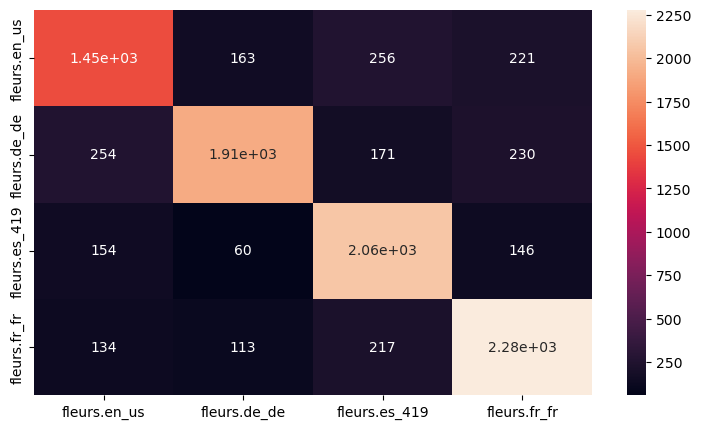

In [10]:
# Confusion matrix:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

preds = model.predict(x_val)
y_classes = preds.argmax(axis=-1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_val.argmax(axis=-1), y_pred = y_classes)

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (9,5))
sn.heatmap(df_cm, annot=True, fmt = '.3g', xticklabels=CLASSES, yticklabels=CLASSES)
plt.show()

In [ ]:
plt.plot(range(0, 10), history.history['categorical_accuracy'])
plt.show()

In [ ]:
with tf.device('/gpu:0'):
    model.evaluate(x_test, y_test, verbose=2)
    pred_test = model.predict(x_test)
    print(tf.math.confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1)))

1074/1074 - 17s - loss: 1.3960 - categorical_accuracy: 0.1944 - 17s/epoch - 16ms/step
   1/1074 [..............................] - ETA: 6:27

2023-04-29 12:22:51.182853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1074/1074 [==============================] - 16s 14ms/step
tf.Tensor(
[[    0     0     0  6055]
 [    0     0     0 10926]
 [    0     0     0 10693]
 [    0     0     0  6680]], shape=(4, 4), dtype=int32)


## Save trained model

In [ ]:
model.save('lab_gsc_no_globalavg.h5')

In [ ]:
# remove softmax
model = tf.keras.Model(model.input, model.layers[-2].output, name=model.name)

In [ ]:
res = kerascnn2c.Converter(output_path=Path('gsc_output_fixed'),
                           fixed_point=FIXED_POINT, # Number of bits for the fractional part, Q7.9 format
                           number_type='int16_t', # Data type for weights/activations (16 bits quantization)
                           long_number_type='int32_t', # Data type for intermediate results
                           number_min=-(2**15), # Minimum value for 16-bit signed integers
                           number_max=(2**15)-1 # Maximum value for 16-bit signed integers
                          ).convert_model(copy.deepcopy(model))
with open('gsc_model_fixed.h', 'w') as f:
    f.write(res)